## Setting

### Optional

In [1]:
!pip install xgboost lightgbm catboost -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 151.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.8/296.8 MB 13.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
root = "/content/drive/MyDrive/Machine Learning"
import sys
sys.path.append(root)

### Required

In [4]:
from open.train_tuning import Model
from open.evaluation import show_confusion_matrix, show_roc_curve, show_pr_curve, show_prediction_score

is_binary = True

## Loading Data

In [5]:
import pickle
import pandas as pd
import numpy as np

use_original_data = False

# Load the pickle file
print("Loading datafile...")
with open(f"/content/drive/MyDrive/4-2 기계학습/open_train_33.pkl", "rb") as f:
    train = pickle.load(f)
    X_train = pd.DataFrame(train["X"])
    X_train.columns = train["feature_names"]
    y_train = train["y_binary"]
    y_train = np.where(y_train == -1, 0, y_train)

with open(f"/content/drive/MyDrive/4-2 기계학습/open_val_33.pkl", "rb") as f:
    val = pickle.load(f)
    X_val = pd.DataFrame(val["X"])
    X_val.columns = train["feature_names"]
    y_val = val["y_binary"]
    y_val = np.where(y_val == -1, 0, y_val)

if use_original_data:
  X_train = train['scaler'].inverse_transform(train['X'])
  X_train = pd.DataFrame(X_train)
  X_train.columns = train['feature_names']

  X_val = val['scaler'].inverse_transform(val['X'])
  X_val = pd.DataFrame(X_val)
  X_val.columns = val['feature_names']

print("Loading complete.")
print("Training data size:\t", len(X_train))
print("Validation data size:\t", len(X_val))

Loading datafile...
Loading complete.
Training data size:	 20300
Validation data size:	 4350


## Model

lightGBM

In [6]:
model_type = "lgb"
param_grid = {
    "n_estimators": [100, 200],      # 2
    "max_depth": [5, 10],            # 2
    "learning_rate": [0.1],          # 1
    "subsample": [1.0],              # 1
    "colsample_bytree": [1.0]        # 1
}


### Base Model Training

In [7]:
model = Model(is_binary=is_binary)
# change the model type and parameters accordingly
model.create_model(model_type, n_estimators = 20)
print(model.hparams)
model.fit(X_train, y_train)

{'n_estimators': 20, 'max_depth': 6, 'learning_rate': 0.3, 'subsample': 1, 'colsample_bytree': 1}
[LightGBM] [Info] Number of positive: 13300, number of negative: 7000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5200
[LightGBM] [Info] Number of data points in the train set: 20300, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.655172 -> initscore=0.641854
[LightGBM] [Info] Start training from score 0.641854


In [8]:
y_test_pred = model.predict(X_val)
y_test_pred

array([1, 1, 1, ..., 0, 0, 0])

In [9]:
model.score(X_val, y_val)

0.9022988505747126

In [10]:
_ = model.k_fold_cv(X_train, y_train, k = 5)

[LightGBM] [Info] Number of positive: 10640, number of negative: 5600
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 16240, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.655172 -> initscore=0.641854
[LightGBM] [Info] Start training from score 0.641854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 10640, number of negative: 5600
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000974 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5143
[LightGBM] [Info] Number of data points in the train set: 16240, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.655172 -> initscore=0.641

### Feature Evaluation

In [11]:
model.get_feature_importances()

{np.str_('burst_std_first30'): 84,
 np.str_('in_first30'): 74,
 np.str_('switch_count_first30'): 50,
 np.str_('burst_max_first30'): 42,
 np.str_('duration'): 39,
 np.str_('burst_mean'): 36,
 np.str_('q75_iat_first30'): 31,
 np.str_('std_iat'): 25,
 np.str_('mean_iat_first30'): 25,
 np.str_('std_iat_first30'): 21,
 np.str_('burst_ratio_in'): 19,
 np.str_('num_out'): 19,
 np.str_('burst_ratio_in_first30'): 18,
 np.str_('switch_count'): 17,
 np.str_('ratio_out'): 16,
 np.str_('burst_max'): 16,
 np.str_('frac_in'): 14,
 np.str_('mean_iat'): 13,
 np.str_('n_packets'): 11,
 np.str_('burst_std'): 8,
 np.str_('num_in'): 7,
 np.str_('out_first30'): 6,
 np.str_('duration_first30'): 4,
 np.str_('burst_mean_first30'): 4,
 np.str_('q75_iat'): 1,
 np.str_('median_iat'): 0,
 np.str_('q25_iat'): 0,
 np.str_('burst_count'): 0,
 np.str_('median_iat_first30'): 0,
 np.str_('q25_iat_first30'): 0,
 np.str_('ratio_out_first30'): 0,
 np.str_('burst_count_first30'): 0,
 np.str_('frac_in_first30'): 0}

### Hyperparameter Tuning

In [12]:
# define parameter search space
bst = model.grid_search(X_train, y_train, param_grid)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Info] Number of positive: 10640, number of negative: 5600
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 16240, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.655172 -> initscore=0.641854
[LightGBM] [Info] Start training from score 0.641854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

### Evaluation

In [13]:
y = y_val
y_pred = bst.predict(X_val)
y_prob = bst.predict_proba(X_val)[:, 1]

1. Confusion Matrix

              precision    recall  f1-score   support

 unmonitored       0.91      0.89      0.90      1500
   monitored       0.94      0.95      0.95      2850

    accuracy                           0.93      4350
   macro avg       0.92      0.92      0.92      4350
weighted avg       0.93      0.93      0.93      4350



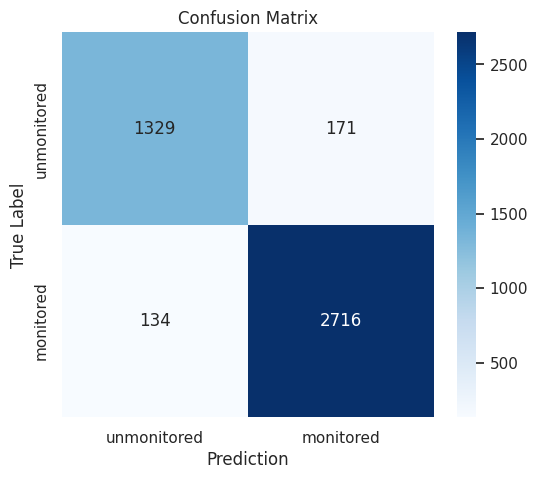

In [14]:
show_confusion_matrix(y, y_pred, model_type)

2. ROC Curve

- ROC AUC Score: 0.9817


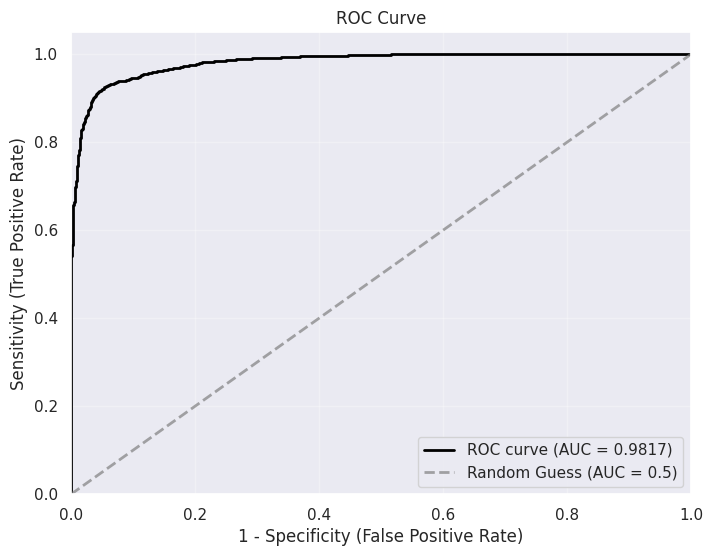

In [15]:
show_roc_curve(y, y_prob, model_type)

3. PR Curve

- Average Precision (AP) Score: 0.9904


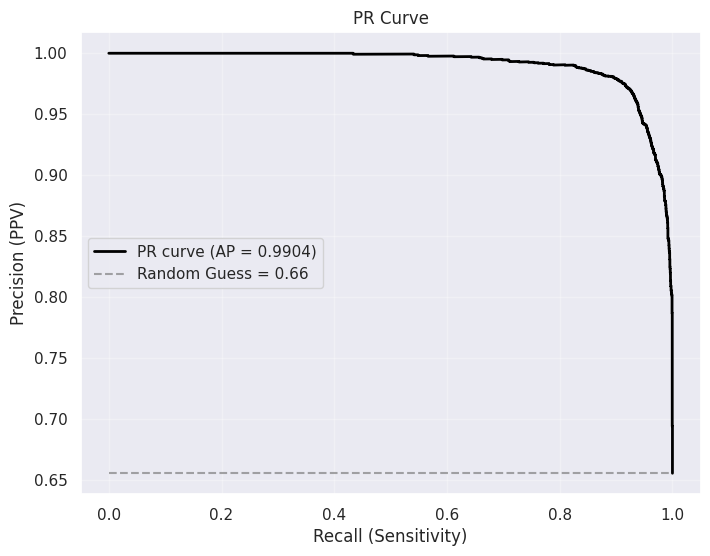

In [16]:
show_pr_curve(y, y_prob, model_type)

4. Prediction Score


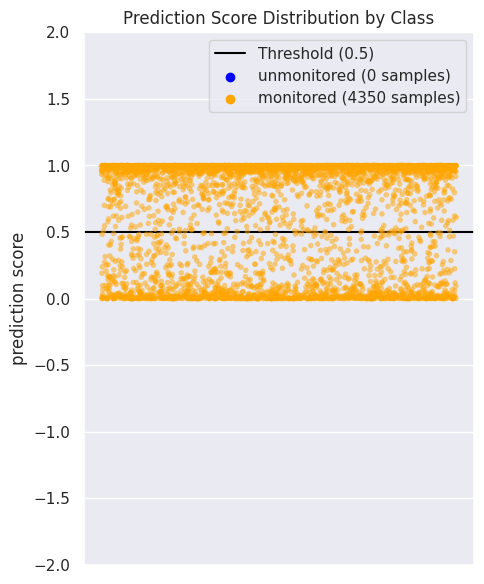

In [17]:
y_fixed = np.where(y == -1, 0, 1)
y = y_fixed

y_prob_fixed = y_prob  # 이미 2-column이면 그대로 씀

show_prediction_score(y, y_prob, model_type)

### Save Model

In [18]:
model.save_model(model=bst.best_estimator_, file_name=f"{bst.best_params_}")

## Model

catboost

In [19]:
model_type = "cat"
param_grid = {
    "n_estimators": [100, 200],      # 2
    "max_depth": [5, 10],            # 2
    "learning_rate": [0.1],          # 1
    "subsample": [1.0],              # 1
}


### Base Model Training

In [20]:
model = Model(is_binary=is_binary)
# change the model type and parameters accordingly
model.create_model(model_type, n_estimators = 20)
print(model.hparams)
model.fit(X_train, y_train)

{'n_estimators': 20, 'max_depth': 6, 'learning_rate': 0.3, 'subsample': 1}
0:	learn: 0.5276847	total: 51.4ms	remaining: 976ms
1:	learn: 0.4349863	total: 54.9ms	remaining: 494ms
2:	learn: 0.3940408	total: 58.6ms	remaining: 332ms
3:	learn: 0.3699538	total: 62.5ms	remaining: 250ms
4:	learn: 0.3516014	total: 66.2ms	remaining: 199ms
5:	learn: 0.3352340	total: 69.9ms	remaining: 163ms
6:	learn: 0.3188746	total: 73.6ms	remaining: 137ms
7:	learn: 0.3123923	total: 77.3ms	remaining: 116ms
8:	learn: 0.3028873	total: 81.2ms	remaining: 99.2ms
9:	learn: 0.2953334	total: 85ms	remaining: 85ms
10:	learn: 0.2869499	total: 88.4ms	remaining: 72.3ms
11:	learn: 0.2813807	total: 92.1ms	remaining: 61.4ms
12:	learn: 0.2747004	total: 95.8ms	remaining: 51.6ms
13:	learn: 0.2695856	total: 99.7ms	remaining: 42.7ms
14:	learn: 0.2667707	total: 103ms	remaining: 34.4ms
15:	learn: 0.2621920	total: 107ms	remaining: 26.8ms
16:	learn: 0.2596641	total: 111ms	remaining: 19.5ms
17:	learn: 0.2569951	total: 114ms	remaining: 12.7

In [21]:
y_test_pred = model.predict(X_val)
y_test_pred

array([1, 1, 1, ..., 0, 0, 0])

In [22]:
model.score(X_val, y_val)

np.float64(0.8967816091954023)

In [23]:
_ = model.k_fold_cv(X_train, y_train, k = 5)

0:	learn: 0.5210032	total: 4.13ms	remaining: 78.5ms
1:	learn: 0.4391151	total: 7.82ms	remaining: 70.4ms
2:	learn: 0.3992229	total: 11.6ms	remaining: 65.5ms
3:	learn: 0.3747893	total: 15.4ms	remaining: 61.6ms
4:	learn: 0.3505825	total: 19ms	remaining: 56.9ms
5:	learn: 0.3314862	total: 22.6ms	remaining: 52.7ms
6:	learn: 0.3212482	total: 27.6ms	remaining: 51.3ms
7:	learn: 0.3099027	total: 31.3ms	remaining: 46.9ms
8:	learn: 0.3037167	total: 34.8ms	remaining: 42.5ms
9:	learn: 0.2978528	total: 38.5ms	remaining: 38.5ms
10:	learn: 0.2911663	total: 41.9ms	remaining: 34.3ms
11:	learn: 0.2870967	total: 45.4ms	remaining: 30.3ms
12:	learn: 0.2801279	total: 49ms	remaining: 26.4ms
13:	learn: 0.2773132	total: 52.4ms	remaining: 22.4ms
14:	learn: 0.2734091	total: 56.1ms	remaining: 18.7ms
15:	learn: 0.2690150	total: 60.7ms	remaining: 15.2ms
16:	learn: 0.2615388	total: 64.3ms	remaining: 11.3ms
17:	learn: 0.2573411	total: 67.8ms	remaining: 7.53ms
18:	learn: 0.2518145	total: 71.2ms	remaining: 3.75ms
19:	lea

### Feature Evaluation

In [24]:
model.get_feature_importances()

{'feature_30': 10.168345848275129,
 'feature_8': 9.959715180420798,
 'feature_19': 9.655062417574987,
 'feature_28': 9.47270113687115,
 'feature_31': 8.374332852802576,
 'feature_18': 6.935300143573235,
 'feature_26': 5.679762149651376,
 'feature_29': 5.469468065154504,
 'feature_32': 4.8994587295617995,
 'feature_20': 4.535233613507931,
 'feature_25': 4.520787795266035,
 'feature_24': 2.7709759610717235,
 'feature_33': 2.7635642827221947,
 'feature_21': 2.7184977640819654,
 'feature_7': 1.8562604301177892,
 'feature_11': 1.5566938643294335,
 'feature_14': 1.4344085175102341,
 'feature_17': 1.3790233817289914,
 'feature_27': 1.3289745720176074,
 'feature_10': 0.6964203621925853,
 'feature_13': 0.6116945824880016,
 'feature_16': 0.5925648970817147,
 'feature_9': 0.5636308995585095,
 'feature_5': 0.5388564976438547,
 'feature_1': 0.4743179125512892,
 'feature_15': 0.37527369166888563,
 'feature_12': 0.21120351622043793,
 'feature_2': 0.19543186177024424,
 'feature_6': 0.18622088719364752

### Hyperparameter Tuning

In [25]:
# define parameter search space
bst = model.grid_search(X_train, y_train, param_grid)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
0:	learn: 0.6281865	total: 3.17ms	remaining: 314ms
1:	learn: 0.5725484	total: 6.01ms	remaining: 295ms
2:	learn: 0.5343057	total: 8.88ms	remaining: 287ms
3:	learn: 0.5054840	total: 11.9ms	remaining: 286ms
4:	learn: 0.4820431	total: 14.7ms	remaining: 280ms
5:	learn: 0.4611535	total: 17.5ms	remaining: 275ms
6:	learn: 0.4433480	total: 20.5ms	remaining: 272ms
7:	learn: 0.4328255	total: 23.3ms	remaining: 267ms
8:	learn: 0.4209562	total: 26ms	remaining: 263ms
9:	learn: 0.4119593	total: 28.9ms	remaining: 260ms
10:	learn: 0.4024380	total: 31.8ms	remaining: 257ms
11:	learn: 0.3945601	total: 34.5ms	remaining: 253ms
12:	learn: 0.3880210	total: 37.4ms	remaining: 250ms
13:	learn: 0.3811489	total: 40.2ms	remaining: 247ms
14:	learn: 0.3741764	total: 42.9ms	remaining: 243ms
15:	learn: 0.3669881	total: 45.5ms	remaining: 239ms
16:	learn: 0.3618305	total: 48.3ms	remaining: 236ms
17:	learn: 0.3548143	total: 51.2ms	remaining: 233ms
18:	learn: 0.350

### Evaluation

In [26]:
y = y_val
y_pred = bst.predict(X_val)
y_prob = bst.predict_proba(X_val)[:, 1]

1. Confusion Matrix

              precision    recall  f1-score   support

 unmonitored       0.91      0.88      0.89      1500
   monitored       0.94      0.96      0.95      2850

    accuracy                           0.93      4350
   macro avg       0.92      0.92      0.92      4350
weighted avg       0.93      0.93      0.93      4350



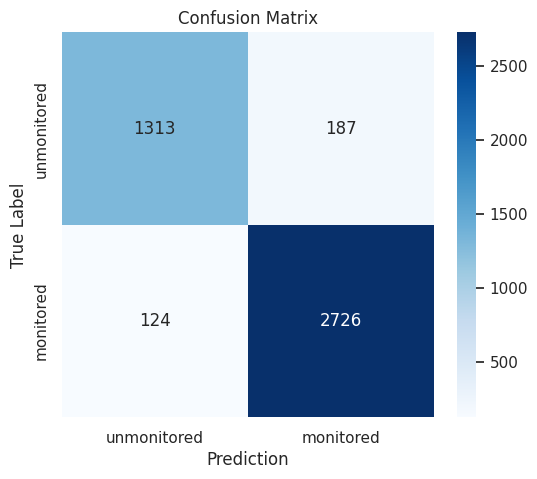

In [27]:
show_confusion_matrix(y, y_pred, model_type)

2. ROC Curve

- ROC AUC Score: 0.9805


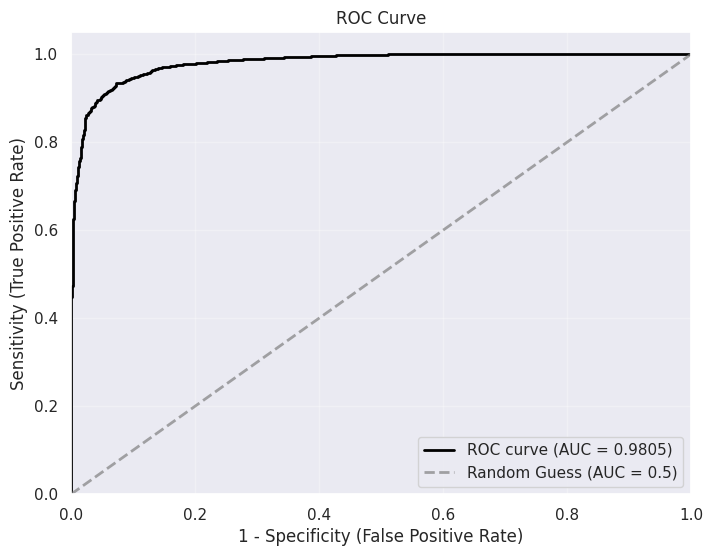

In [28]:
show_roc_curve(y, y_prob, model_type)

3. PR Curve

- Average Precision (AP) Score: 0.9895


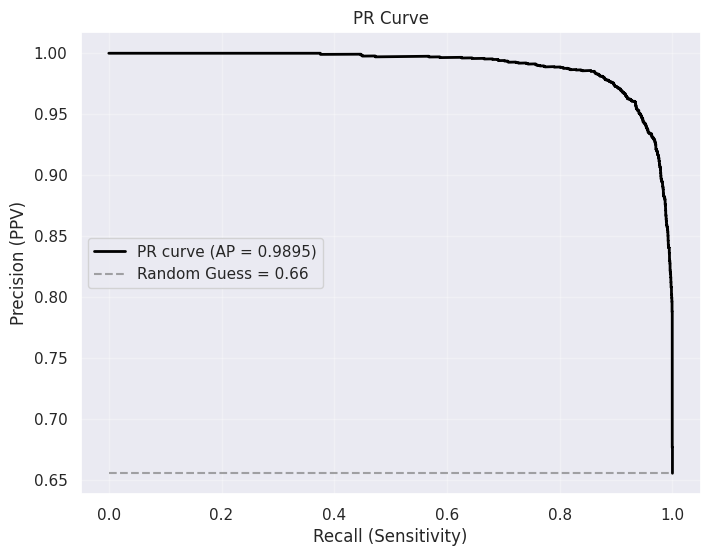

In [29]:
show_pr_curve(y, y_prob, model_type)

4. Prediction Score


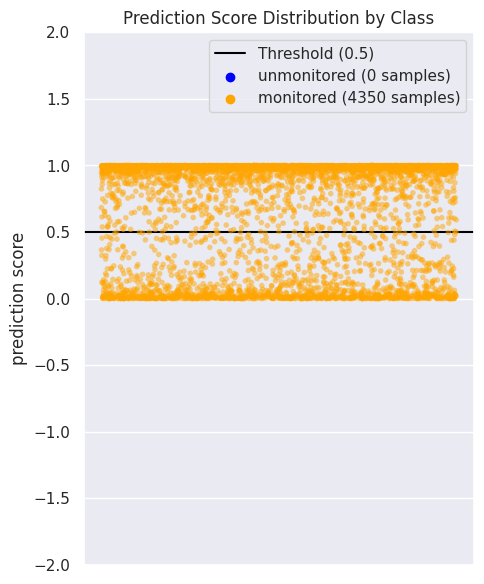

In [30]:
y_fixed = np.where(y == -1, 0, 1)
y = y_fixed

y_prob_fixed = y_prob  # 이미 2-column이면 그대로 씀

show_prediction_score(y, y_prob, model_type)


### Save Model

In [31]:
model.save_model(model=bst.best_estimator_, file_name=f"{bst.best_params_}")